While working on a post about implementing interpolation from scratch, I wanted to check my 2D bicubic interpolation against some existing libraries. Surprisingly, they don't agree!

I haven't gotten to the bottom of **why**, but I thought it worthwhile to document with an example. Let's import the tools we need:

In [1]:
%config InlineBackend.figure_formats = ['retina']
%config InlineBackend.print_figure_kwargs = {'facecolor': (1.0, 1.0, 1.0, 0.0)}
import numpy as np
import matplotlib.pyplot as plt

plt.rc('image', cmap='PuOr', origin='lower')
plt.rc('figure', figsize=(5, 2))

import doodads as dd  # my personal utility library, used only for plotting

Let's construct a signal that should interpolate fairly well. We're going to use sinusoids well within the band-limit of the image, so it's theoretically possible to interpolate and upsample without introducing aliasing*.

<span style="font-size: 80%;">* Under some assumptions like infinite periodicity and using sinc interpolation... we're not doing that. But we should get close!</span>

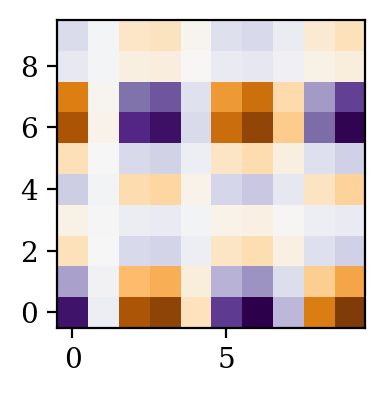

In [2]:
def f(xx, yy):
    phase = np.pi/6
    return 2 * np.cos(xx + phase) * np.cos(yy / 2) * np.cos(yy)

samples = 10
xmin, xmax = 0, samples - 1
dx = 1
img_extent = [xmin - dx/2, xmax + dx/2, xmin - dx/2, xmax + dx/2]
coords = np.arange(samples)
xx, yy = np.meshgrid(coords, coords)

img = f(xx, yy)
plt.imshow(img, extent=img_extent)

Here we've evaluated $f(x, y) = \cos(x / 2) \cos (y / 2) \cos(y)$ at the centers of pixels $0 \le x \le 9$ and $0 \le y \le 9$. (Note the `extent=` argument to `imshow` making the tick marks land in the right spot, taking into account the pixel extent from $x - 0.5$ to $x + 0.5$.)

Since it's analytic, we can make a "truth" signal that's sampled 100x more finely in $x$ and $y$.

In [3]:
upsample = 100
upsample_coords = np.linspace(-dx/2, samples - dx / 2, upsample * samples)
upsample_coords = np.arange(upsample * samples) / upsample - 0.5  # subtract half a pixel to account for finite size

Here we plot the coarsely-sampled signal on the left and the more finely sampled "truth" signal on the right.

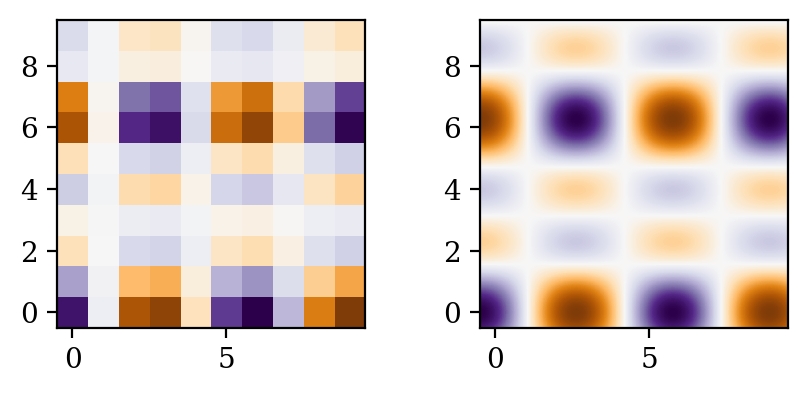

In [4]:
xx, yy = np.meshgrid(upsample_coords, upsample_coords)
upsampled_truth = f(xx, yy)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(upsampled_truth, extent=img_extent)

We can also pull out one row of the coarsely-sampled signal and plot it signal-processing style:

<StemContainer object of 3 artists>

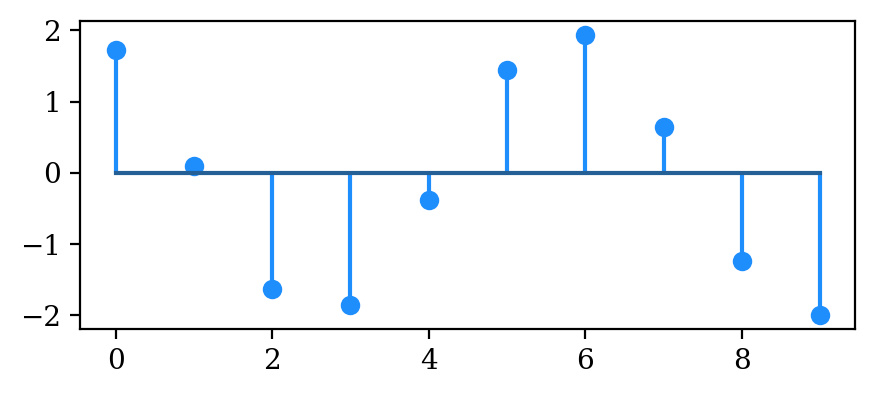

In [5]:
plt.stem(coords, img[0])

The first row of the image (i.e. $y=0$) should be row 50 in our upsampled image indexing:

In [6]:
np.argwhere(upsample_coords == 0)

array([[50]])

We can overplot the "truth" signal and make sure it passes through the original points, as a check:

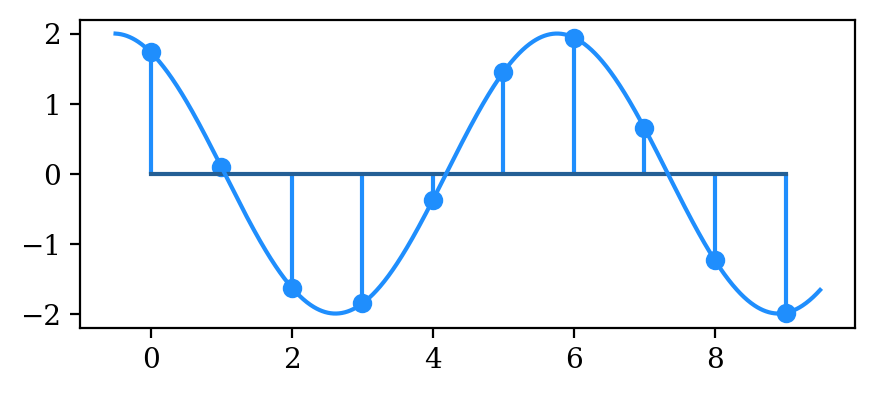

In [7]:
plt.stem(coords, img[0])
plt.plot(upsample_coords, upsampled_truth[50])

Now, let's upsample the original coarsely sampled image using interpolation and see if it agrees with the truth! The new image size is just the original size multiplied by `upsample`.

In [8]:
dsize = (img.shape[0] * upsample, img.shape[1] * upsample)

## scikit-image interpolation

Scikit-image requires some additional options get it to behave as (I) expected. Unlike linear interpolation, cubic interpolation can produce values outside the range of the input—that is well-known. However, the scikit-image interpolation functions require you to pass `clip=False` to get the expected behavior.

First let's look at the default behavior (`clip=True`):

np.min(img)=-1.99
np.max(img)=1.94
np.min(upsampled_truth)=-2.0
np.max(upsampled_truth)=2.0
np.min(upsampled_skimage_bad)=-1.99
np.max(upsampled_skimage_bad)=1.94


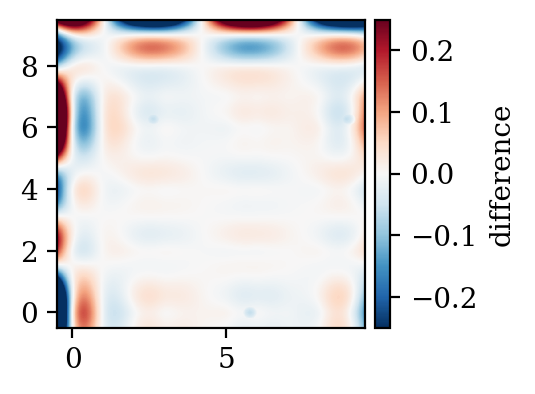

In [9]:
# scikit-image
from skimage import transform

upsampled_skimage_bad = transform.resize(img, dsize, order=3)
dd.show_diff(upsampled_skimage_bad, upsampled_truth,
             as_percent=False, extent=img_extent, vmax=0.25, colorbar=True)
print(f"{np.min(img)=:1.3}\n{np.max(img)=:1.3}")
print(f"{np.min(upsampled_truth)=:1.3}\n{np.max(upsampled_truth)=:1.3}")
print(f"{np.min(upsampled_skimage_bad)=:1.3}\n{np.max(upsampled_skimage_bad)=:1.3}")

Above, you can see that the `upsampled_skimage_bad` array has identical minimum and maximum pixel values to the original image. The $f(x, y)$ we defined has extrema that don't perfectly align with a sample location, so imposing this `clip=True` constraint means we'll definitely disagree with the "truth" image. 

The plot is a difference image, subtracting the "ground truth" from the interpolation. You can see a couple of little "pimples" where the clipping has moved a predicted value and made it a worse approximation. For our purposes, we want `clip=False`.

With that pre-requisite dealt with, we can resize the image and compare the interpolation to the ground truth.

In [10]:
upsampled_skimage = transform.resize(img, dsize, order=3, clip=False)

Now, we plot the interpolated image and truth image on identical color scales, as well as the difference image. Below, values from row 0 of the interpolated image (orange) are overlaid on the original and finely-sampled truth image.

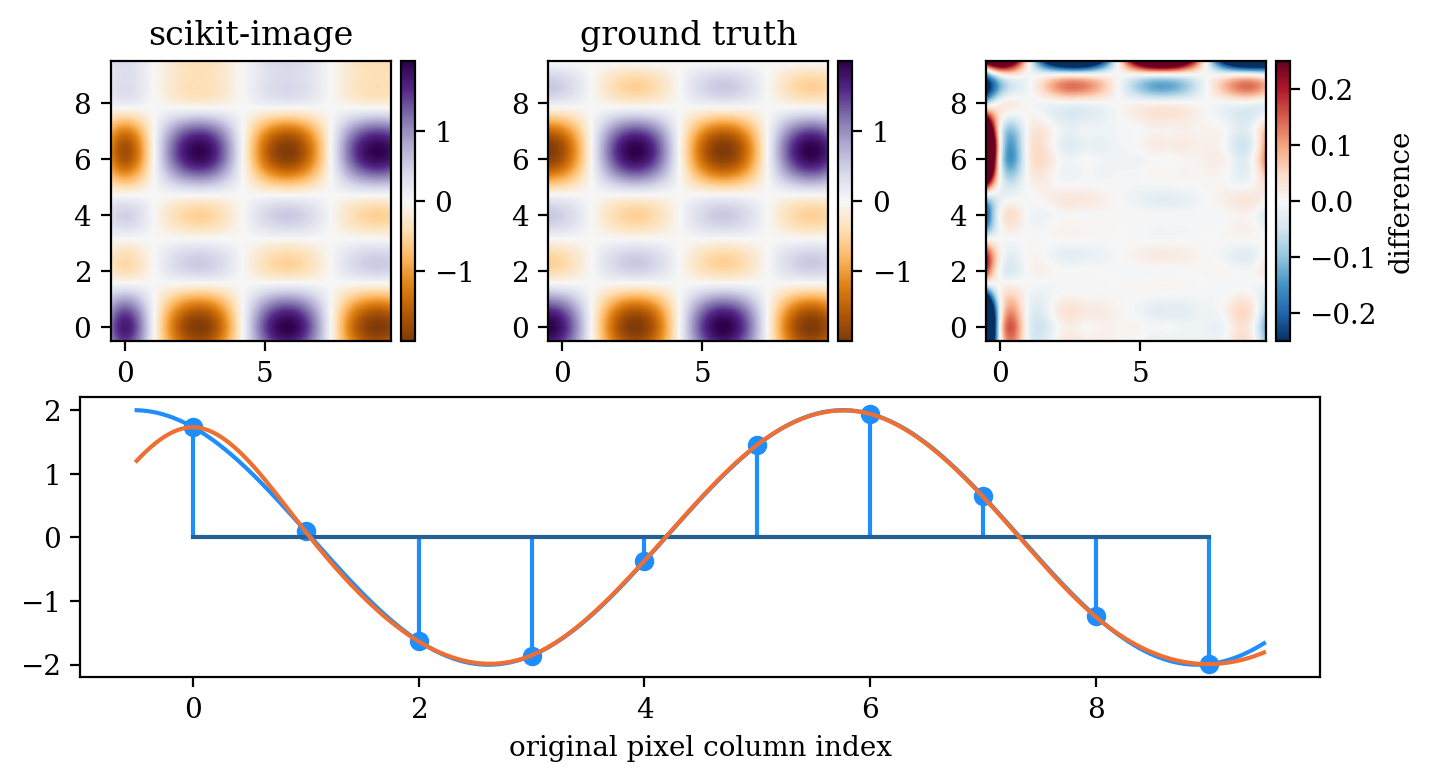

In [11]:
def comparison_plot(title, orig, truth, upsampled, row=0):
    fig, axs = plt.subplot_mosaic('abc\nddd', figsize=(8, 4))
    axs['d'].stem(coords, orig[row])
    upsampled_idx = upsample // 2 + row * upsample
    axs['d'].plot(upsample_coords, truth[upsampled_idx])
    axs['d'].plot(upsample_coords, upsampled[upsampled_idx])
    axs['d'].set(
        xlabel='original pixel column index'
    )
    dd.three_panel_diff_plot(
        upsampled, truth,
        as_percent=False,
        extent=img_extent,
        colorbar=True,
        ax_a=axs['a'], title_a=title,
        ax_b=axs['b'], title_b='ground truth',
        ax_aminusb=axs['c'],
        diff_kwargs=dict(vmax=0.25),
    )

comparison_plot('scikit-image', img, upsampled_truth, upsampled_skimage)

Performance at the edges is worse, as may be expected. The bicubic interpolation domain needs $4 \times 4$ pixel values, and the edge pixels only have that on one or two sides.

Of course, choosing the `mode=` differently will give you different behavior at the hairy edges. None of these options is more "right" than the others but you should know that argument exists in case you need it.

Text(0.5, 1.0, 'constant')

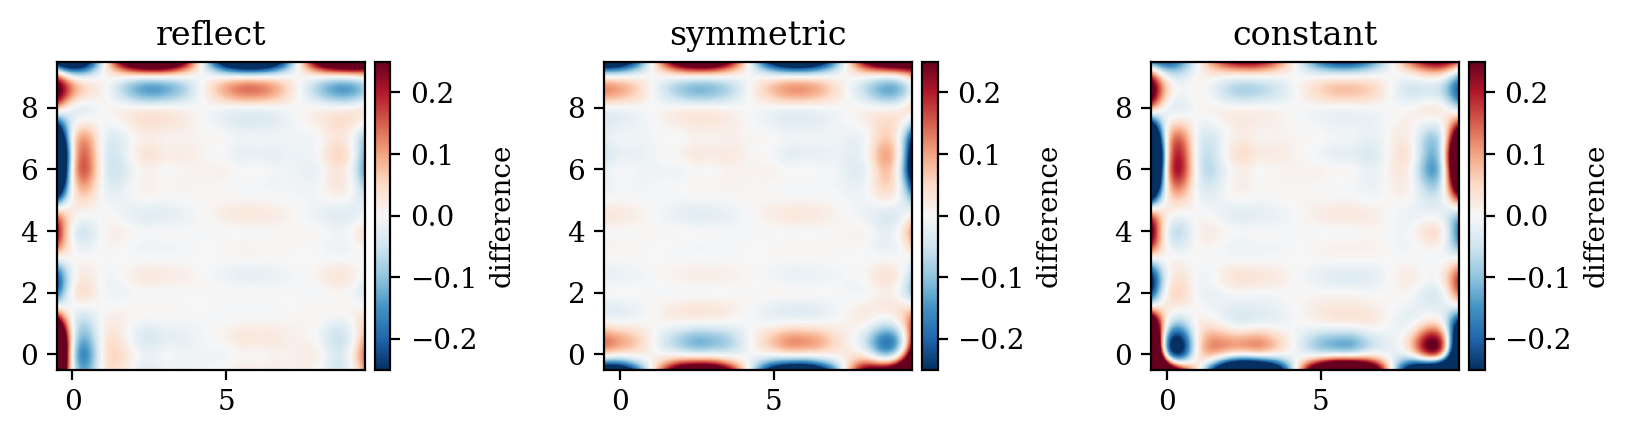

In [12]:
upsampled_skimage_symm = transform.resize(img, dsize, order=3, clip=False, mode='symmetric')
upsampled_skimage_const = transform.resize(img, dsize, order=3, clip=False, mode='constant')

fig, axs = plt.subplots(ncols=3, figsize=(10, 2))
dd.show_diff(upsampled_truth, upsampled_skimage, as_percent=False, extent=img_extent, vmax=0.25, colorbar=True, ax=axs[0])
dd.show_diff(upsampled_truth, upsampled_skimage_symm, as_percent=False, extent=img_extent, vmax=0.25, colorbar=True, ax=axs[1])
dd.show_diff(upsampled_truth, upsampled_skimage_const, as_percent=False, extent=img_extent, vmax=0.25, colorbar=True, ax=axs[2])
axs[0].set_title("reflect")
axs[1].set_title("symmetric")
axs[2].set_title("constant")

### Aside: scikit-image and data types

There's another footgun to be aware of in scikit-image when working with camera images, which are not floating-point by default. Since our sample signal **is** floating-point, illustrating this require defining a new sample image `mini_img` with `dtype=np.uint16` (like a 10- or 12-bit camera might produce):

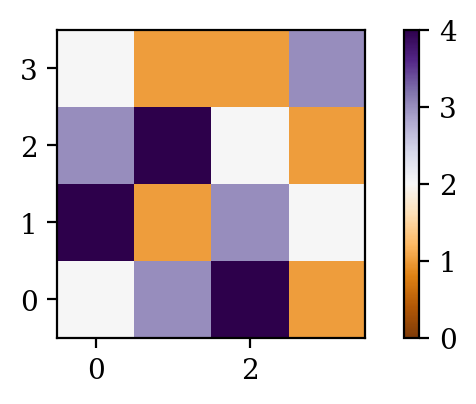

In [13]:
mini_img = np.array([
    [2, 3, 4, 1],
    [4, 1, 3, 2],
    [3, 4, 2, 1],
    [2, 1, 1, 3],
], dtype=np.uint16)
plt.colorbar(plt.imshow(mini_img, vmin=0))

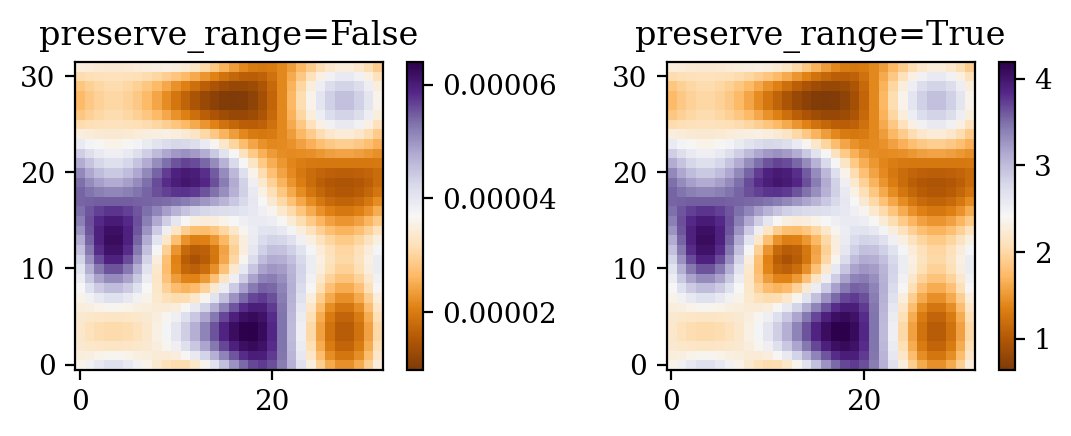

In [14]:
mini_img_upsample = transform.resize(mini_img, (32, 32), order=3, clip=False)
mini_img_upsample_preserve = transform.resize(mini_img, (32, 32), order=3, preserve_range=True, clip=False)

fig, axs = plt.subplots(ncols=2, figsize=(7, 2))
axs[0].set(title='preserve_range=False')
cb1 = fig.colorbar(axs[0].imshow(mini_img_upsample))
cb1.formatter.set_scientific(False)
axs[1].set(title='preserve_range=True')
fig.colorbar(axs[1].imshow(mini_img_upsample_preserve))


The image on the left uses the default behavior and the image on the right uses the `preserve_range=True` option. The one on the left has pretty dramatically different values because it has been automatically rescaled from the dynamic range of a 16-bit integer into the interval [0, 1] of a floating point representation. In astronomical image processing this is not usually what you want.

So, we said above we don't want to blindly preserve the range of the inputs by clipping, but now we must supply `preserve_range=True` to actually get the desired behavior. 

This is somewhat confusing.

In any case, official scikit-image documentation even [says not to use floating point images with values beyond the $[-1, 1]$ interval](https://scikit-image.org/docs/stable/user_guide/data_types.html), so maybe this library is best left for the computer vision people.

## OpenCV

Speaking of computer vision people, that's what the CV in "OpenCV" stands for. They implement the core algorithms of computer vision as a compiled C++ library with Python bindings, so they're quite fast.

My friend [Dr. Logan Pearce](http://www.loganpearcescience.com/) relies on their implementation of interpolation, so let's see how it stacks up.

In [15]:
# OpenCV
import cv2

upsampled_cv = cv2.resize(img, dsize, interpolation=cv2.INTER_CUBIC)

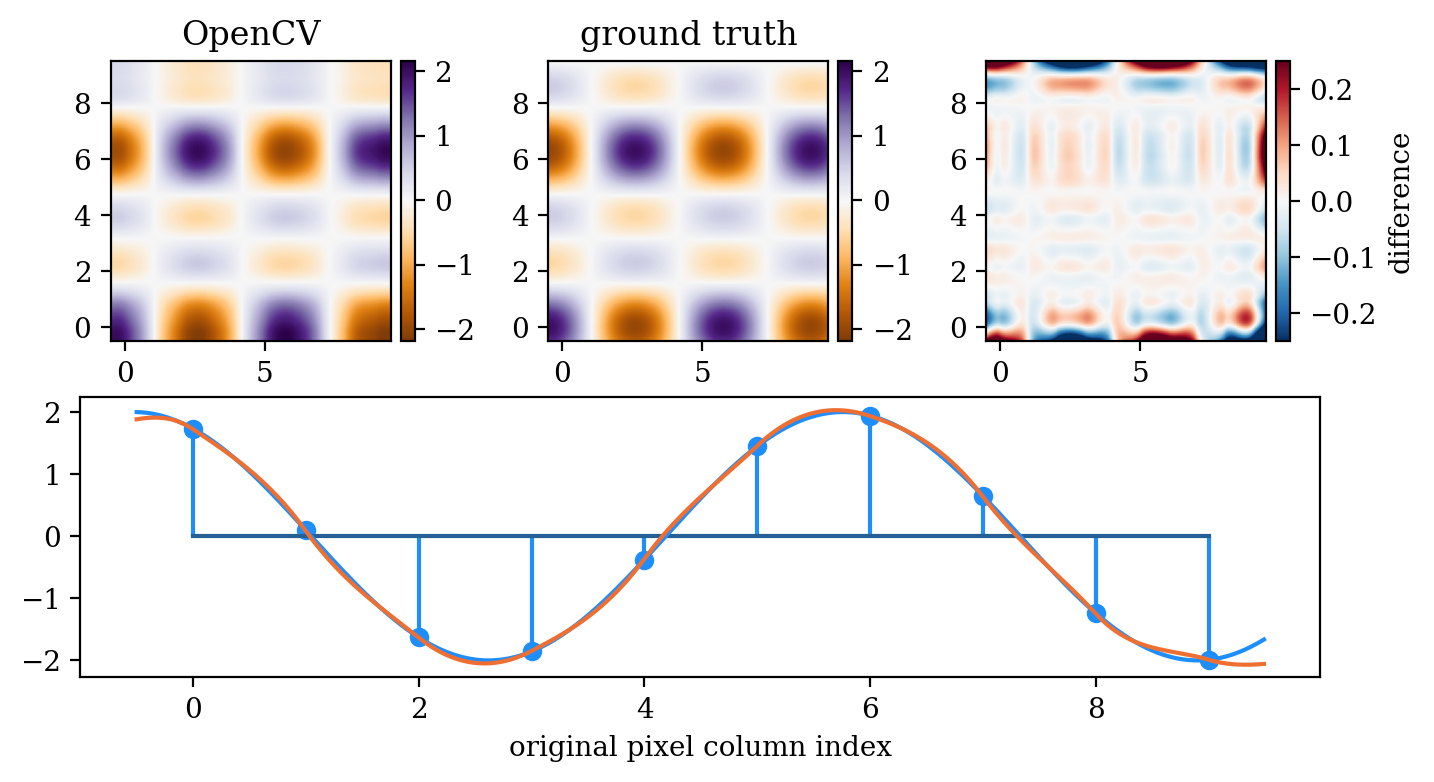

In [16]:
comparison_plot('OpenCV', img, upsampled_truth, upsampled_cv)

As expected, the values near the edges are a bit off where interpolation became extrapolation. Otherwise, pretty similar to scikit-image (though with fewer extra arguments required to get normal behavior).

There's one place where OpenCV really shines though:

In [17]:
%timeit cv2.resize(img, dsize, interpolation=cv2.INTER_CUBIC)

392 µs ± 7.25 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
%timeit transform.resize(img, dsize, order=3, clip=False)

58.1 ms ± 678 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


It's a nice couple **orders of magnitude** faster to run, compared to the scikit-image function we used above.

## scipy.ndimage

The default behavior of `scipy.ndimage` transformation functions is surprising.

In [19]:
# scipy
from scipy.ndimage import zoom

upsampled_scipy_bad = zoom(img, upsample, order=3)

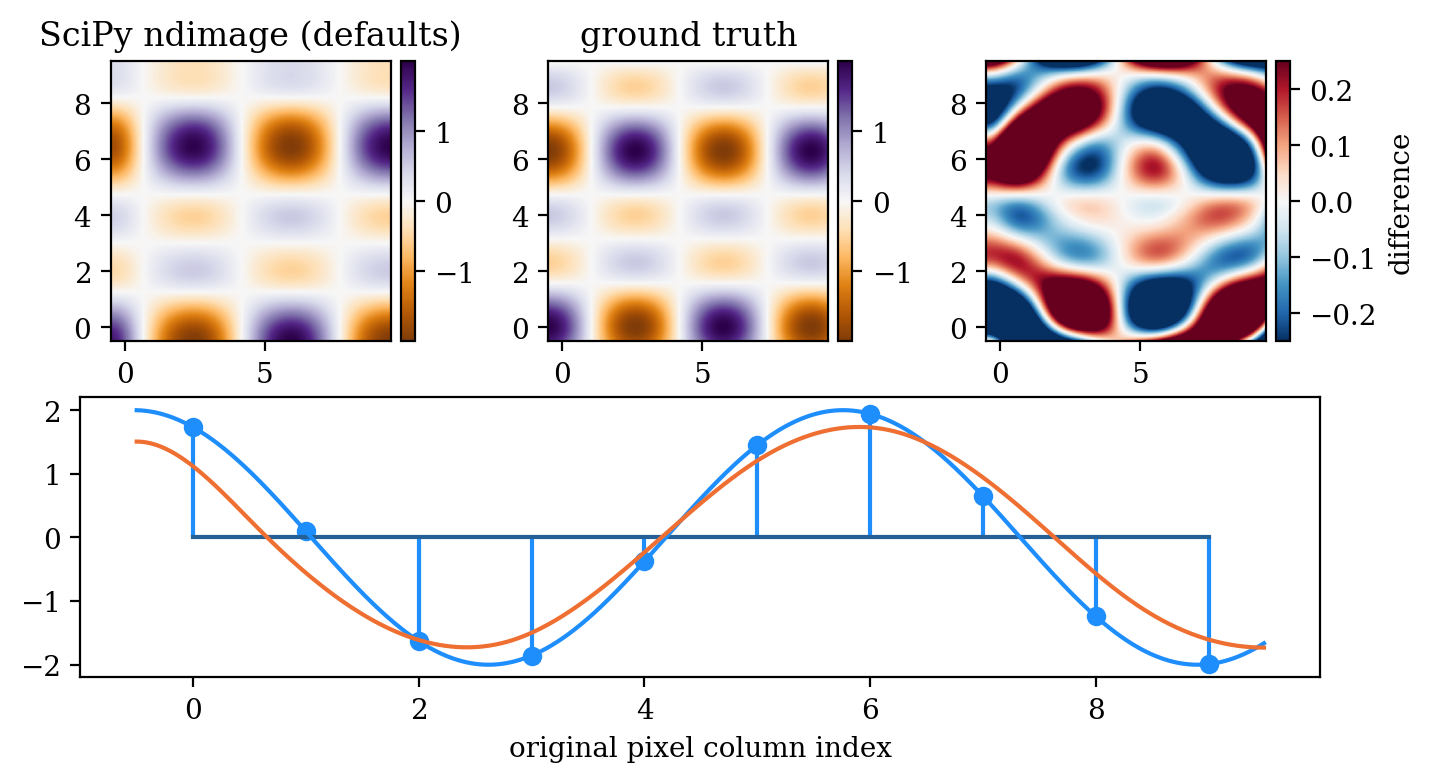

In [20]:
comparison_plot('SciPy ndimage (defaults)', img, upsampled_truth, upsampled_scipy_bad)

Well, that's clearly... not what we wanted.

It turns out that SciPy's implementation does not match our intuition about finitely-sized pixels. In astronomical images, a camera pixel is a physical thing that has a width and a height, so we take the pixel coordinates as the value of a pixel-sized patch centered on the pixel coordinates. That's how we can have a value for -0.49 in the examples above. To the SciPy interpolator, a sample is an infinitely small point with a known value (a ["knot"](https://stats.stackexchange.com/a/517479)) to constrain the path of a spline.

So, to SciPy, the image we're asking to `zoom()` actually starts at $(0, 0)$ and not $(-0.5, -0.5)$. That puts $(0, 0)$ in the first element of the row we plotted as a lollipop plot. If we started our upsampled coordinates at 0 instead of -0.5, we'd see what they intended.

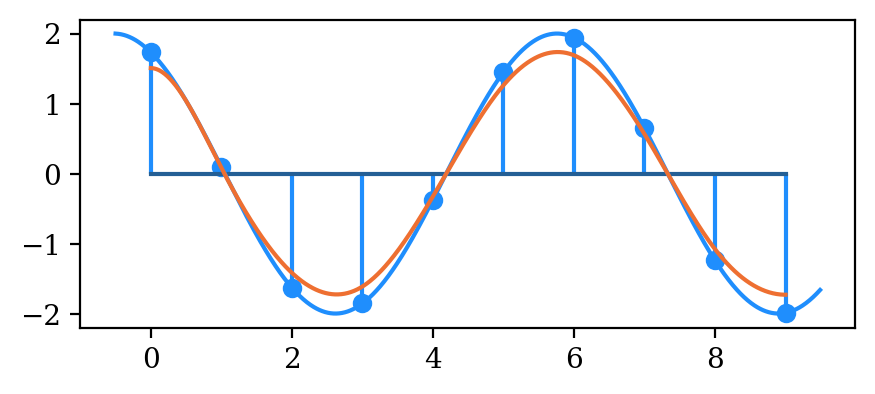

In [21]:
plt.stem(coords, img[0])
plt.plot(upsample_coords, upsampled_truth[50])
plt.plot(np.linspace(0, samples - 1, upsample * samples), upsampled_scipy_bad[50])

This is... still not what we wanted. 

It's not clear to me what's going on with the missing amplitude. It's also counter-intuitive for e.g. integrating. If all your pixels represent an area $1 \times 1$ but the edges have area $0.5 \times 1$ and the corners $0.5 \times 0.5$, you may confuse yourself. (Of course, you shouldn't zoom before integrating...) 

SciPy supports the more intuitive interpretation for signal processing with the `grid_mode=True` argument to `zoom()`, which produces something more like the expected output. (Ignore the warning for the moment.)

In [22]:
upsampled_scipy_bad2 = zoom(img, upsample, order=3, grid_mode=True)

/Users/josephlong/mambaforge/envs/py310/lib/python3.10/site-packages/scipy/ndimage/_interpolation.py:801: UserWarning: It is recommended to use mode = grid-constant instead of constant when grid_mode is True.
  warnings.warn(


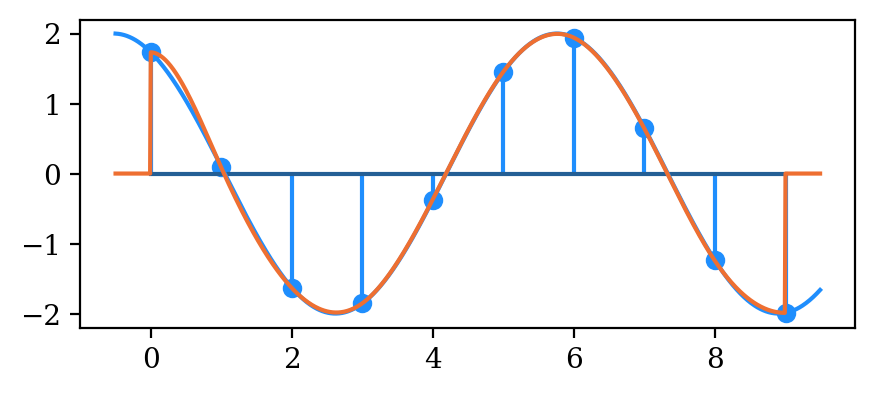

In [23]:
plt.stem(coords, img[0])
plt.plot(upsample_coords, upsampled_truth[50])
plt.plot(upsample_coords, upsampled_scipy_bad2[50])

Here, the difference in indexing convention rears up again in the form of clamping all values outside $0 \le x \le 9$ to zero. You must also supply a `mode` argument to interpolate those pixel values. (That's what the warning above is about, though `mode='grid-constant'` is not the only valid choice.)

In [24]:
upsampled_scipy = zoom(img, upsample, order=3, grid_mode=True, mode='grid-mirror')

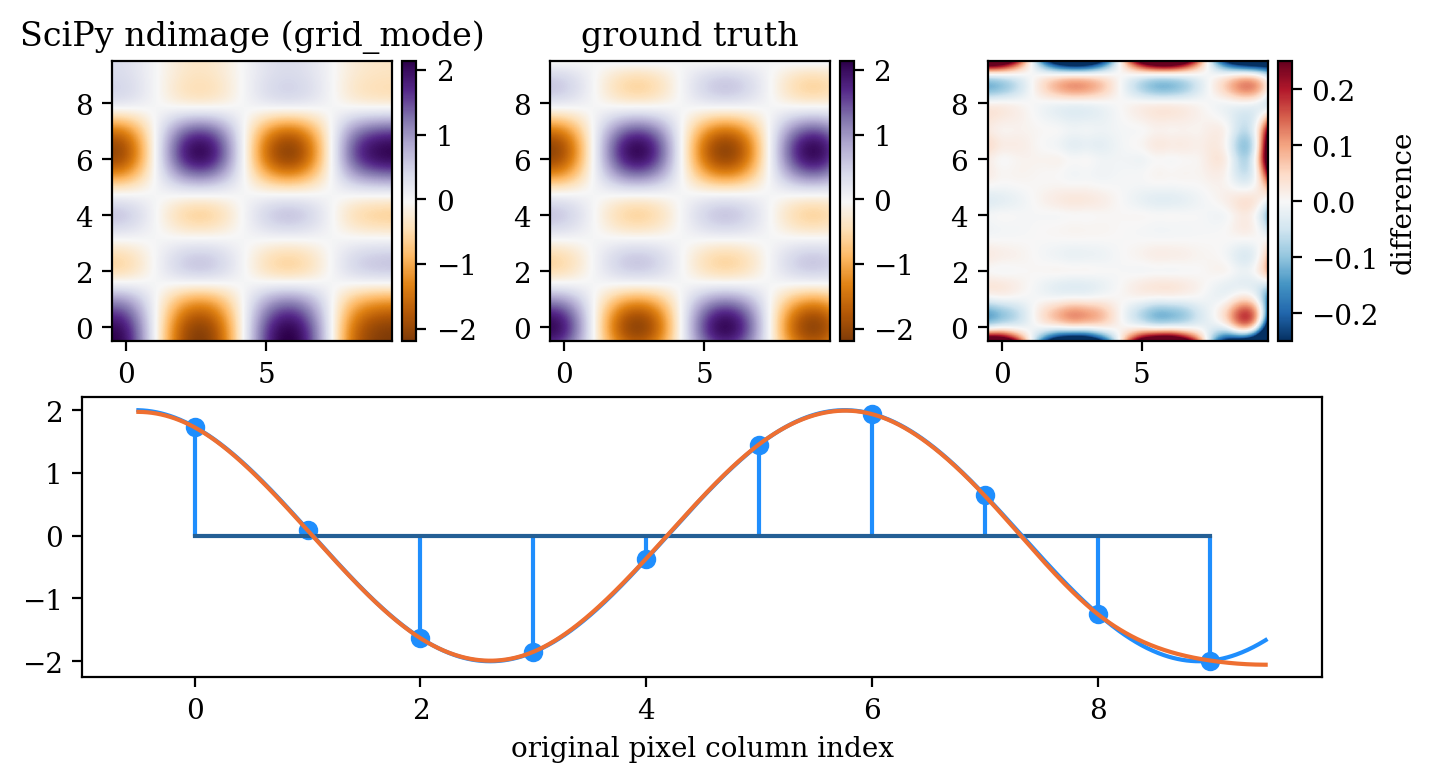

In [25]:
comparison_plot('SciPy ndimage (grid_mode)', img, upsampled_truth, upsampled_scipy)

Runtime-wise, performance is comparable to scikit-image.

In [26]:
%timeit zoom(img, upsample, order=3, grid_mode=True, mode='grid-mirror')

58 ms ± 717 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)



Of course, `zoom()` just happened to be a convenient test operation to compare. In practice, you'll want to be able to apply arbitrary affine transformations or even distortion solutions in your interpolation step. 

Since the default options apply assumptions that conflict with our intuition for finite-size pixels, I wouldn't recommend the SciPy ndimage functions for that. There may be other implications of the assumed indexing convention that crop up later on.

## scipy.interpolate

Fortunately, `scipy.interpolate`'s default behavior is a lot more intuitive. Unfortunately, depending on whether you start out searching for "rotate image scipy" or "interpolate data scipy", you could end up in either `ndimage` or `interpolate` docs without any idea that there's two options.

The [RectBivariateSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html) class supports spline interpolation of 2D data with regular spacing.

In [27]:
from scipy.interpolate import RectBivariateSpline

It takes in 1D arrays for the $x$ and $y$ coordinates of a 2D array of pixels/samples. There's a pitfall here that we'll explore in a moment.

In [28]:
rbvs_interp = RectBivariateSpline(coords, coords, img)

The resulting object can be called with 1D arrays of new $x$ and $y$ coordinates, like `upsample_coords` from above.

In [29]:
upsampled_rbvs = rbvs_interp(upsample_coords, upsample_coords)

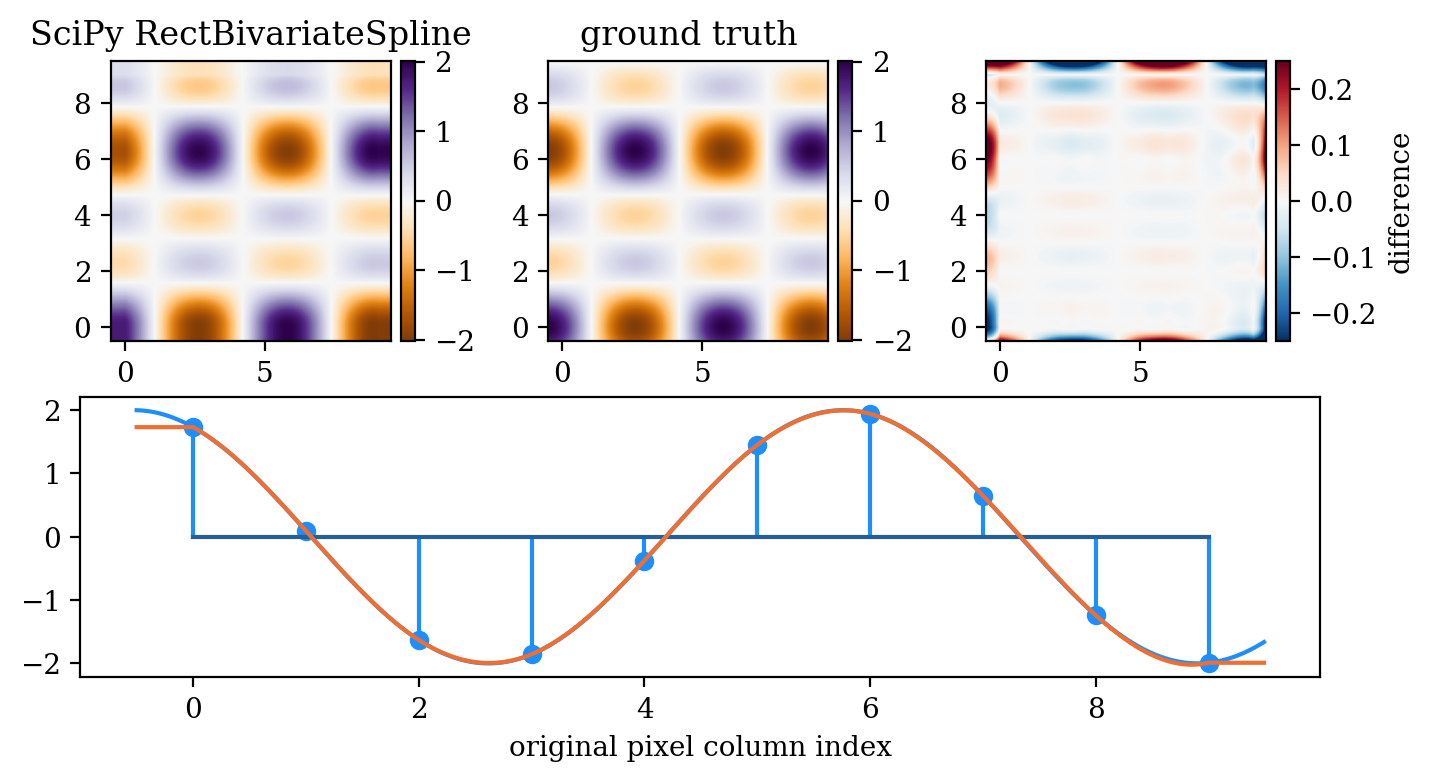

In [30]:
comparison_plot('SciPy RectBivariateSpline', img, upsampled_truth, upsampled_rbvs)

Possibly noteworthy: the computation time is almost all at interpolation time, not instantiation time. Unfortunately, that means pre-constructing and reusing `RectBivariateSpline` instances doesn't add much in terms of efficiency.

In [31]:
%timeit RectBivariateSpline(coords, coords, img)

16.5 µs ± 46.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [32]:
%timeit rbvs_interp(upsample_coords, upsample_coords)

8.97 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The good news is that it's about six times faster than scikit-image for this example case, albeit still an order of magnitude slower than OpenCV. Possibly more *accurate* than OpenCV, though, since it's using spline interpolation instead of (I think) cubic convolution.

Now, what's the catch?

### A confusion of `x` and `y`

The `scipy.interpolate` functions for 2D interpolation adopt a naming convention at odds with how matplotlib shows images. For an array of shape `(4, 5)`, `RectBivariateSpline` would call 4 the number of `x` samples and 5 the number of `y` samples. Plotting the array, however, will show four *rows* of five *columns*.

The [documentation](https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.interpolate.RectBivariateSpline.__call__.html#scipy.interpolate.RectBivariateSpline.__call__) for the callable `rbvs_interp` points this out:

```
        x, y : array_like
            Input coordinates.

            If `grid` is False, evaluate the spline at points ``(x[i],
            y[i]), i=0, ..., len(x)-1``.  Standard Numpy broadcasting
            is obeyed.

            If `grid` is True: evaluate spline at the grid points
            defined by the coordinate arrays x, y. The arrays must be
            sorted to increasing order.

            The ordering of axes is consistent with
            ``np.meshgrid(..., indexing="ij")`` and inconsistent with the
            default ordering ``np.meshgrid(..., indexing="xy")``.
```

The last sentence tells us that where RectBivariateSpline is concerned `x` is the first axis, `y` is the second.

Of course, interpreting any block of memory as an image is a matter of establishing conventions. For example, the default behavior of matplotlib is to place the origin (i.e. pixel (0, 0)) at upper left, as you would for printing out a matrix (left to right, top to bottom). (This causes consternation for astronomers, who place the origin at lower left, but the default can be changed. This customization was made up there in the very first cell.)

The risk is that non-square images and transformations that do different things to x and y coordinates will not behave as expected. For example, we can translate the interpolated grid by subtracting an offset from `upsample_coords`.

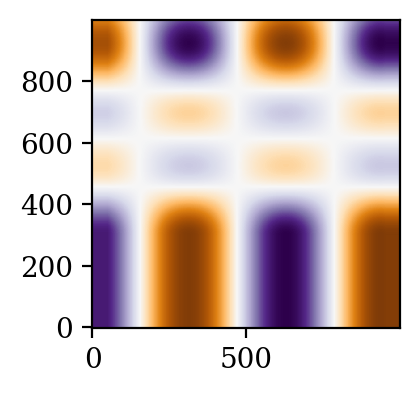

In [33]:
offset_x = 2.5
plt.imshow(rbvs_interp(upsample_coords - offset_x, upsample_coords))

**That's not what we wanted!** The resulting image has been translated by `offset_x` in the direction represented by the first axis of `img`: i.e., the $y$ direction. So, to translate horizontally, we adjust the second coordinate argument (which it calls `y`).

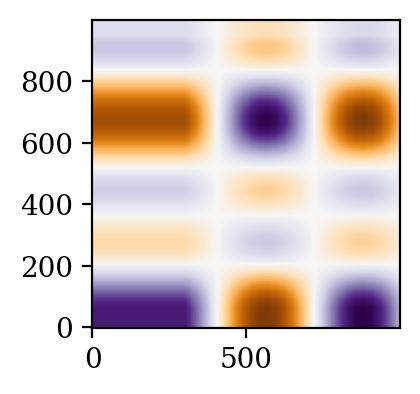

In [34]:
plt.imshow(rbvs_interp(upsample_coords, upsample_coords - offset_x))

This API only allows translation and scaling, because the 1D coordinate vectors give a constant `x` across a row / constant `y` along a column. Fortunately, since SciPy version 0.14.0, the RectBivariateSpline interpolator accepts a `grid=False` argument. Supplying all the `x`s and `y`s allows arbitrary transformations *and* handily sidesteps confusion about axis naming/ordering (since you are responsible for reshaping from a 1D vector of interpolated values back into a 2D array).

There would be an example of that here, but this post is long enough already.

## Which interpolation function should I use for image processing in Python?

For speed, ergonomics of API, and (approximate) correctness, I have to agree with Dr. Pearce: the [OpenCV geometric transformations](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html) functions are the way to go. If you watch out for the `x`/`y` switcharoo, [SciPy's RectBivariateSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html) may provide better accuracy at the cost of slower calculations.

(Or, of course, you could implement it yourself! That way you know exactly what it's doing with your precious pixels of data.)

*Thanks to [Philip Mocz](https://pmocz.github.io/) and [Louis Desdoigts](https://github.com/LouisDesdoigts) for help tracking down what SciPy ndimage is doing.*